In [1]:
import numpy as np

from matplotlib import pyplot as plt
from citk.layer import Dense, GMDHLayer
from citk.model import FFN
from citk.functions import ReLU, Linear
from citk.losses import MSE
from citk.optimisers import SGDOptimizer

from utils import get_and_process_boston_dataset, visualise_boston, seed_everything

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Data

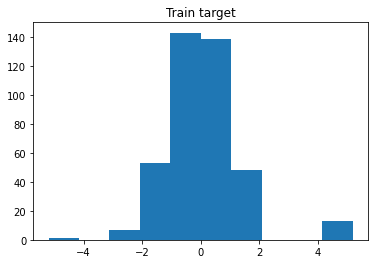

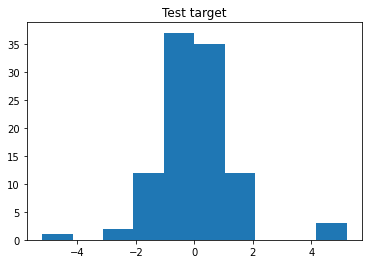

In [2]:
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

X_train, X_test, y_train, y_test = get_and_process_boston_dataset(random_state=RANDOM_SEED)

visualise_boston(X_train, X_test, y_train, y_test)

# Create Model

In [3]:
model = FFN(
    input_shape=X_train.shape[1], 
    layer_specs=[
        GMDHLayer(poli_type='partial_quadratic', nonlinearity=ReLU),
        Dense(1, nonlinearity=Linear)
    ], 
    loss=MSE, 
    reg_coef=0.01
)

## Train Model

In [4]:
trained, history = model.fit(
    train_sample=(X_train, y_train),
    validation_sample=(X_test, y_test),
    optimiser=SGDOptimizer(alpha=0.01),
    batch_size=32,
    epochs=7_000,
    verbose=False
)

# Predict and Visualise losses

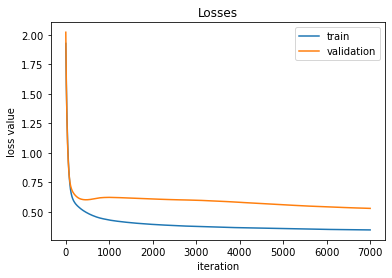

In [5]:
plt.title('Losses')
plt.plot(history['train_loss'], label='train')
plt.plot(history['validation_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [6]:
prediction = trained.predict(X_test)
prediction_train = trained.predict(X_train)

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.5287055677930111
Train MSE: 0.2466162241469375


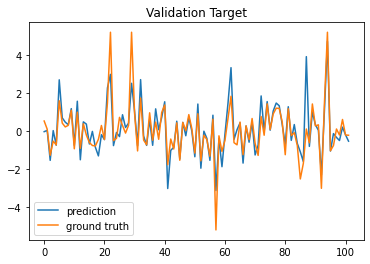

In [7]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

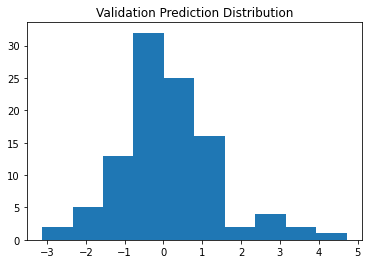

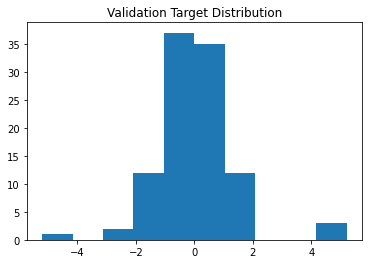

In [8]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()